<a id="top"></a>
# UN SDG Indicator 6.6.1:<br> Change in the Extent of Water-related Ecosystems


<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.

In the first section, one time period is analyzed. The mean of water classifications over time is visualized, the minimum and maximum water extents are visualized, and the frequency of water classification for each pixel is visualized.

In the second section, two time periods are analyzed - a baseline time period and an analysis time period. The change in pixels that are water at any time during their respective time periods is calculated, the change in water from the baseline time period to the analysis time period is visualized, and the area is classified by degree of change using classification labels provided by UN SDG 6.6.1.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platform and Product](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Analyze a Single Time Period](#single_period)
    * [Define the Extents of the Analysis](#define_extents_single) (selecting too much can make the acquisition process slow)
    * [Retrieve the Data from the Datacube](#retrieve_data_single)
    * [Get Water Classifications](#calculate_single)
    * [Prepare for Visualization](#prepare_for_vis)
    * [Find the Minimum and Maximum Water Extents](#find_water_extents)
    * [Create Water Extent Image](#water_extent_image)
    * [Create Time Series Plot of the Mean of Water](#time_series_water)
* [Compare Two Time Periods - a Baseline and an Analysis](#two_period)
    * [Define the Extents of the Analysis](#define_extents_baseline_analysis)
    * [Retrieve the Data from the Datacube](#retrieve_data_baseline_analysis)
    * [Get Water Classifications](#calculate_baseline_analysis)
    * [Calculate Change in Water from the Baseline Period to the Analysis Period](#calculate_water_change)
    * [Create a Change Figure](#change_figure)
    * [Classify the Area by Degree of Change](#classify_by_degree_change)

## <a id="import"></a>Import Dependencies and Connect to the Data Cube [&#9652;](#top)

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt

# Allow importing of our utilities.
import sys
sys.path.append("..")

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Create an instance of the datacube and API.
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = api.dc

## <a id="plat_prod"></a>Choose Platform and Product [&#9652;](#top)

**List available products for each platform**

In [4]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
0,LANDSAT_7,ls7_collections_sr_scene
1,LANDSAT_7,ls7_ledaps_vietnam
2,LANDSAT_7,ls7_ledaps_vietnam_sample


In [5]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,


**Choose products**

In [6]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
use_Landsat7 = True
use_Landsat8 = False
platforms = []
products = []
# Work around some missing data for the Landsat 7 Tanzania product.
# if use_Landsat7:
#     platforms.append('LANDSAT_7')
#     products.append('ls7_ledaps_tanzania')
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_vietnam_sample')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_tanzania')
# The fraction of the original resolution to use for analysis.
# Use this to control memory consumption and run time.
frac_res = 0.25

## <a id="extents"></a>Get the Extents of the Cube [&#9652;](#top)

In [7]:
from utils.data_cube_utilities.dc_load import get_overlapping_area
# Get the area common to all products.
full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

In [8]:
from utils.data_cube_utilities.dc_time import dt_to_str
print("Available Latitude Extents:", full_lat)
print("Available Longitude Extents:", full_lon)
print("Available Time Extents:", np.vectorize(dt_to_str)(min_max_dates))

Available Latitude Extents: (9.189495861962364, 10.375541531586)
Available Longitude Extents: (103.75541531586, 105.4262817443232)
Available Time Extents: [['2014-11-20' '2015-01-23']]


## <a id="single_period"></a>Analyze a Single Time Period  [&#9652;](#top)

### <a id="define_extents_single"></a>Define the Extents of the Analysis [&#9652;](#top)

**Specify start and end dates**

In [9]:
# Select a subset of the time available.
date_range = [dt.datetime(2016,1,1), dt.datetime(2018,1,1)]

In [10]:
# Select a subset of the time available.
date_range = [dt.datetime(2014,1,1), dt.datetime(2016,1,1)]

**Specify an area to analyze**

In [11]:
# Specify latitude and longitude bounds of an interesting area within the full extents.

# Ghana
# min_lat_small, max_lat_small = (6.5016, 6.5221) # Lake Volta (very small)
# min_lon_small, max_lon_small = (-0.1618, -0.100) # Lake Volta (very small)
# min_lat_small, max_lat_small = (6.5016, 6.5821) # Lake Volta (small)
# min_lon_small, max_lon_small = (-0.1618, -0.055) # Lake Volta (small)
# min_lat_small, max_lat_small = (6.5138, 6.5292) # Lake Volta (medium)
# min_lon_small, max_lon_small = (-0.1669, -0.1493) # Lake Volta (medium)
# min_lat_small, max_lat_small = (6.2989, 7.9287) # Lake Volta (large)
# min_lon_small, max_lon_small = (-0.4559, 0.2637) # Lake Volta (large)

# Lake Sulunga, Tanzania
# min_lat_small, max_lat_small = (-6.3605, -5.8252) # Large 
# min_lon_small, max_lon_small = (34.9756, 35.4535) # Large
min_lat_small, max_lat_small = (-6.2593, -5.8701) # Small (close fit)
min_lon_small, max_lon_small = (34.9901, 35.3641) #  Small (close fit)

# Lake Manyara, Tanzania
# min_lat_small, max_lat_small = (-3.8505, -3.3886) 
# min_lon_small, max_lon_small = (35.7184, 35.9271)

# Vietnam
min_lat_small, max_lat_small = (10.037934, 10.237934) 
min_lon_small, max_lon_small = (104.992264, 105.192264)

**Visualize the selected area**

In [12]:
from utils.data_cube_utilities.dc_display_map import display_map
lon_small = (min_lon_small, max_lon_small)
lat_small = (min_lat_small, max_lat_small)
display_map(lat_small, lon_small)

### <a id="retrieve_data_single"></a>Retrieve the Data from the Datacube [&#9652;](#top)

In [13]:
from utils.data_cube_utilities.dc_load import load_multiplatform

measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
dataset, clean_mask, masks = \
    load_multiplatform(dc, platforms, products, frac_res=frac_res,
                       load_params=dict(lat=lat_small, lon=lon_small, 
                                        time=date_range,
                                        measurements=measurements))

### <a id="calculate_single"></a> Get Water Classifications [&#9652;](#top)

In [14]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_utilities import ignore_warnings
from xarray.ufuncs import logical_and as xr_and

cleaned_dataset = dataset.where(clean_mask) # Clean the dataset
wofs_arr = ignore_warnings(wofs_classify, cleaned_dataset).wofs
wofs_arr = wofs_arr.where(xr_and((wofs_arr!=-9999), clean_mask))
cleaned_dataset['water'] = wofs_arr

### <a id="prepare_for_vis"></a> Prepare for Visualization [&#9652;](#top)

In [15]:
# Define a standard dpi to tune font sizes in figures.
# A higher dpi and a lower figure size will result in larger 
# font sizes relative to the figure size.
std_dpi = 100

### <a id="find_water_extents"></a>**Find the Minimum and Maximum Water Extents** [&#9652;](#top)

**We are finding the minimum and maximum water extents based on a max-composite of water data. We do this to reduce the appearance of missing data due to cloud cover and to avoid cluttering a plot of the mean of water over time later.**

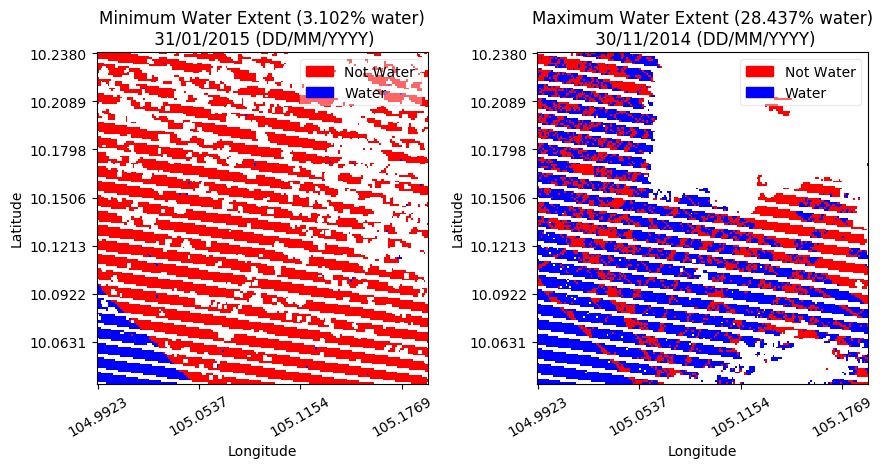

In [16]:
from utils.data_cube_utilities.plotter_utils import figure_ratio, create_discrete_color_map,\
                                                    xarray_imshow

# Find the minimum, mean, and maximum water extents by month.
bin_str = '1m'
resampled_data = cleaned_dataset.water.resample(time=bin_str)
min_water, mean_water, max_water = resampled_data.min(dim='time'), \
    resampled_data.mean(dim='time'), resampled_data.max(dim='time')

# Find the acquisition with the least water.
# Treat the time with the most non-water pixels as the time with the least water.
min_extent_time_ind = max_water.where(max_water == 0).count(['latitude', 'longitude']).argmax().values
min_extent_acq = max_water.isel(time=min_extent_time_ind)

# Find the acquisition with the most water.
max_extent_time_ind = max_water.where(max_water == 1).count(['latitude', 'longitude']).argmax().values
max_extent_acq = max_water.isel(time=max_extent_time_ind)

# Begin plotting the data
fig_width = 9 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(cleaned_dataset, fixed_width=fig_width), dpi=std_dpi)

# Create common colormap.
cmap = create_discrete_color_map([0,1], ['red', 'blue'])

imshow_kwargs = dict(vmin=0, vmax=1, cmap=cmap)

legend_labels = {0:'Not Water', 1:'Water'}

# Minimum water acqusition
ax = plt.subplot(1,2,1)
fig, ax, im, cbar = \
    xarray_imshow(min_extent_acq, fig=fig, ax=ax, use_colorbar=False, use_legend=True, 
                  legend_labels=legend_labels, imshow_kwargs=imshow_kwargs)
ax.set_title("Minimum Water Extent ({1:.3%} water)\n {0}"\
             .format(pd.to_datetime(str(min_extent_acq.time.values)).strftime('%d/%m/%Y (DD/MM/YYYY)'), 
                     np.nansum(min_extent_acq.values) / min_extent_acq.size))

# Maximum water acqusition
ax = plt.subplot(1,2,2)
fig, ax, im, cbar = \
    xarray_imshow(max_extent_acq, fig=fig, ax=ax, use_colorbar=False, use_legend=True, 
                  legend_labels=legend_labels, imshow_kwargs=imshow_kwargs)
ax.set_title("Maximum Water Extent ({1:.3%} water)\n {0}"\
             .format(pd.to_datetime(str(max_extent_acq.time.values)).strftime('%d/%m/%Y (DD/MM/YYYY)'), 
                     np.nansum(max_extent_acq.values) / max_extent_acq.size))

plt.tight_layout()
plt.show()

### <a id="water_extent_image"></a>**Create Water Extent Image** [&#9652;](#top)

Percent of pixels that were never water: 48.503%
Percent of pixels that were sometimes water: 12.316%
Percent of pixels that were always water: 17.840%
Percent of pixels with insufficient data for categorization: 21.341%


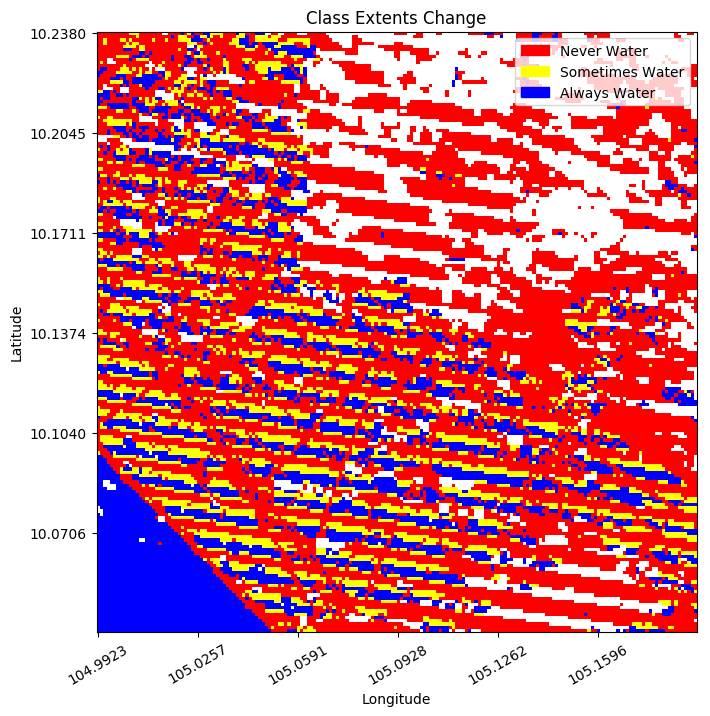

In [17]:
from utils.data_cube_utilities.plotter_utils import binary_class_change_plot

fig_width = 6 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(cleaned_dataset, fixed_width=fig_width), dpi=std_dpi)

# Shade 3 regions - never, sometimes, and always water.
(fig,ax), [pct_none, pct_chng, pct_perm, pct_unknown] = \
    binary_class_change_plot(
        [cleaned_dataset.water], colors=['red', 'yellow', 'blue'], 
        class_legend_label='Water', fig=fig)

print("Percent of pixels that were never water: {0:.3%}".format(pct_none))
print("Percent of pixels that were sometimes water: {0:.3%}".format(pct_chng))
print("Percent of pixels that were always water: {0:.3%}".format(pct_perm))
print("Percent of pixels with insufficient data for categorization: {0:.3%}".format(pct_unknown))

plt.show()

### <a id="time_series_water"></a>Create Time Series Plot of the Mean of Water [&#9652;](#top)

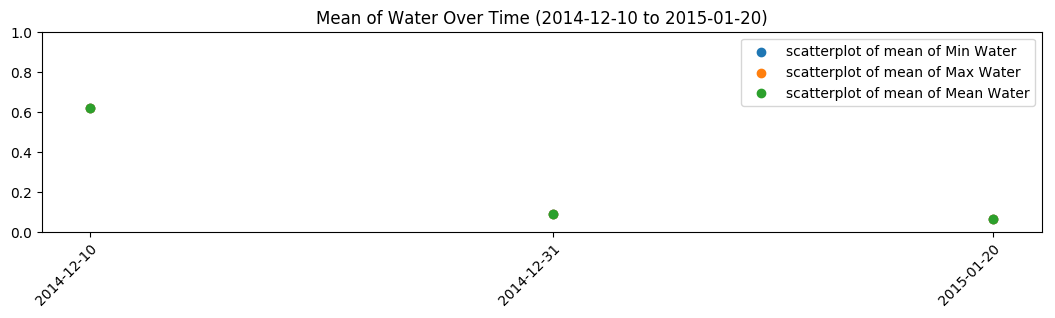

In [18]:
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot
from utils.data_cube_utilities.aggregate import xr_sel_time_by_bin

water_ds = xr.Dataset(data_vars={"Min Water":min_water, "Mean Water":mean_water, 
                                 "Max Water":max_water})

# Show only some of the times to avoid cluttering the figure with tick labels.
plotting_data = xr_sel_time_by_bin(water_ds, num_bins=min(30, len(water_ds.time)))

figsize = (10, 2) # The width and height of the figure, respectively.
fig = plt.figure(figsize=figsize, dpi=std_dpi)

xarray_time_series_plot(plotting_data, fig=fig,
                        plot_descs={'Min Water':  {'mean': [{'scatter': {}}]},
                                    'Mean Water': {'mean': [{'scatter': {}}]},
                                    'Max Water':  {'mean': [{'scatter': {}}]}},
                        show_legend=True, title='Mean of Water Over Time')
plt.ylim(0,1)
plt.show()

## <a id="two_period"></a>Compare Two Time Periods - a Baseline and an Analysis [&#9652;](#top)

### <a id="define_extents_baseline_analysis"></a>Define the Extents of the Analysis [&#9652;](#top)

**Specify start and end dates in the same order as platforms and products**

In [19]:
# Select a subset of the time available.
date_ranges = {'baseline': [dt.datetime(2014,1,1), dt.datetime(2016,1,1)],
               'analysis': [dt.datetime(2016,1,1), dt.datetime(2018,1,1)]}

In [20]:
# Select a subset of the time available.
date_ranges = {'baseline': [dt.datetime(2014,1,1), dt.datetime(2015,1,1)],
               'analysis': [dt.datetime(2015,1,1), dt.datetime(2016,1,1)]}

**Visualize the selected area**

In [21]:
lon_small = (min_lon_small, max_lon_small)
lat_small = (min_lat_small, max_lat_small)
display_map(lat_small, lon_small)

### <a id="retrieve_data_baseline_analysis"></a>Retrieve the Data from the Datacube [&#9652;](#top)

In [22]:
from utils.data_cube_utilities.dc_load import load_multiplatform

cleaned_datasets = {} # Maps categories to cleaned datasets.
clean_masks = {} # Maps categories to clean masks.
measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
# Load the baseline and analysis datasets.
for category in date_ranges.keys():
    dataset, clean_masks[category], masks = \
        load_multiplatform(dc, platforms, products, frac_res=frac_res,
                           load_params=dict(lat=lat_small, lon=lon_small, 
                                            time=date_ranges[category],
                                            measurements=measurements))
    cleaned_datasets[category] = dataset.where(clean_masks[category])
del dataset # Save memory

### <a id="calculate_baseline_analysis"></a>Get Water Classifications [&#9652;](#top)

In [23]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_utilities import ignore_warnings

for category in cleaned_datasets:
    wofs_arr = ignore_warnings(wofs_classify, cleaned_datasets[category]).wofs
    wofs_arr = wofs_arr.where(xr_and((wofs_arr!=-9999), clean_masks[category]))
    cleaned_datasets[category]['water'] = wofs_arr

### <a id="calculate_water_change"></a>**Calculate Change in Water from the Baseline Period to the Analysis Period** [&#9652;](#top)

In [24]:
baseline_ds = cleaned_datasets['baseline']
baseline_sum_cls = baseline_ds.water.sum(dim='time')
analysis_ds = cleaned_datasets['analysis']
analysis_sum_cls = analysis_ds.water.sum(dim='time')

# If a pixel was classified as water at any time during its time period, it is considered water.
baseline_frac_cls_ever = (0 < baseline_sum_cls).values.sum() / baseline_sum_cls.size
analysis_frac_cls_ever = (0 < analysis_sum_cls).values.sum() / analysis_sum_cls.size
# Calculate fractional change as the difference in the fraction of pixels ever classified as water.
frac_change_cls = (analysis_frac_cls_ever - baseline_frac_cls_ever) / baseline_frac_cls_ever
print("Between the baseline ({0} to {1}) and analysis ({2} to {3}) time periods, the change in pixels "\
      "that are water at any time during their respective time periods is:{4:.3%}".format(
        date_ranges['baseline'][0].strftime('%Y-%m-%d'), date_ranges['baseline'][1].strftime('%Y-%m-%d'), 
        date_ranges['analysis'][0].strftime('%Y-%m-%d'), date_ranges['analysis'][1].strftime('%Y-%m-%d'), 
        frac_change_cls))

Between the baseline (2014-01-01 to 2015-01-01) and analysis (2015-01-01 to 2016-01-01) time periods, the change in pixels that are water at any time during their respective time periods is:-89.246%


### <a id="change_figure"></a>**Create a Change Figure** [&#9652;](#top)

Percent of pixels that were never water: 8.050%
Percent of pixels that changed from no water to water: 0.014%
Percent of pixels that changed from water to no water: 11.715%
Percent of pixels that were always water: 1.786%
Percent of pixels with insufficient data for categorization: 78.434%


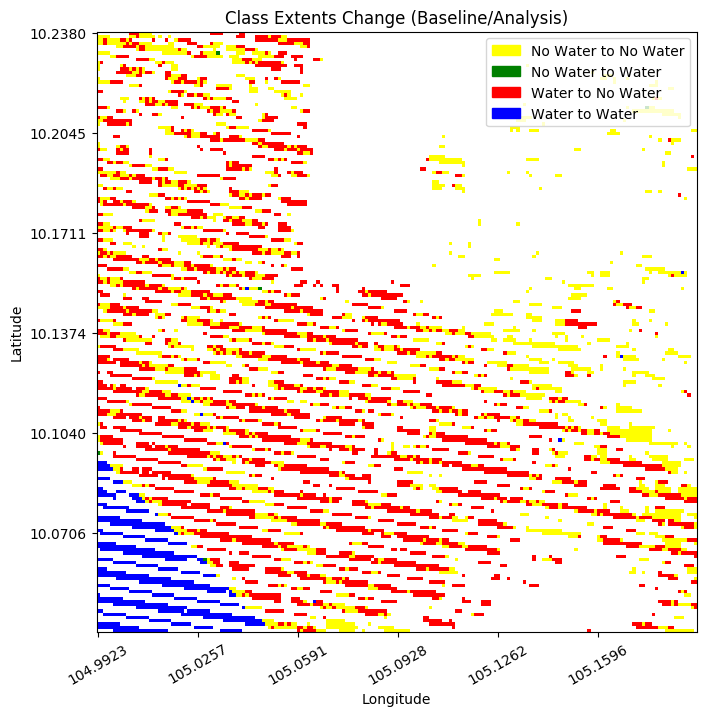

In [25]:
fig_width = 6 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(baseline_ds, fixed_width=fig_width), dpi=std_dpi)

# Show regions based on changes between having zero or more than zero times in which they are classified as water 
# between the two time periods.
[fig,ax], [pct_never_never, pct_never_some, pct_some_never, pct_some_some, pct_unknown] = \
    binary_class_change_plot(
        [baseline_ds.water, analysis_ds.water], 
        colors=['yellow', 'green', 'red', 'blue'], class_legend_label='Water', 
        fig=fig)

print("Percent of pixels that were never water: {0:.3%}"
      .format(pct_never_never))
print("Percent of pixels that changed from no water to water: {0:.3%}"
      .format(pct_never_some))
print("Percent of pixels that changed from water to no water: {0:.3%}"
      .format(pct_some_never))
print("Percent of pixels that were always water: {0:.3%}"
      .format(pct_some_some))
print("Percent of pixels with insufficient data for categorization: {0:.3%}"
      .format(pct_unknown))

plt.show()

### <a id="classify_by_degree_change"></a>**Classifiy the Area by Degree of Change** [&#9652;](#top)

In [26]:
region_class = None
frac_change_cls = abs(frac_change_cls)
if frac_change_cls <= 0.1:
    region_class = "Unmodified Natural (class A)"
if 0.1 < frac_change_cls <= 0.2:
    region_class = "Largely Natural (class B)"
if 0.2 < frac_change_cls <= 0.4:
    region_class = "Moderately Modified (class C)"
if 0.4 < frac_change_cls <= 0.6:
    region_class = "Largely Modified (class D)"
if 0.6 < frac_change_cls:
    region_class = "Seriously Modified (class E)"
print("The percent of pixels that have changed class relative to the baseline time period " \
      "is {0:.3%}, so this region can be classfied as {1}".format(frac_change_cls, region_class))

The percent of pixels that have changed class relative to the baseline time period is 89.246%, so this region can be classfied as Seriously Modified (class E)
